In [1]:
import sys, requests, json
sys.path.insert(1, '../../scripts/')
from s3_support import *

import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

%matplotlib inline

# load data

## logs

In [10]:
# get participant logs for 2018+
# entity type 10: registrants/participants
q = "select * from logs where entitytype=10 and created>='2018-01-01'"
logs = redshift_query_read(q, schema='production')

In [11]:
mn_entries = logs.groupby('entity')['id'].count().mean()

print("{:,} log entries".format(len(logs)))
print("{:,.2f} log entries per participant".format(mn_entries))
print("{:,} orgs, {:,} forms".format(len(logs['org'].unique()), len(logs['form'].unique())))

3,677,324 log entries
5.99 log entries per participant
1,510 orgs, 7,782 forms


In [12]:
def reduce_message(m):
    messages = {
        'reached their fundraising goal': 'reached fundraising goal',
        'Upload Your Avatar': 'uploaded avatar',
        'Raise Your First Donation': 'first donation',
        'Send a Fundraising Email': 'sent email',
        'donation was made to %registration': 'received donation',
        'made a donation to %registration': 'received donation',
        'has earned the %badge': 'earned badge',
        'had the %badge': 'lost badge',
        'Recruit a Team Member': 'recruited team member',
        'donated %amount': 'received donation',
        'Update Your Personal Page': 'updated personal page',
        'Share on Facebook / Twitter': 'social share',
        'switched donation': 'switched donation',
        'was donated to %registration': 'received donation',
        'verified donation': 'verified donation'
    }
    
    for message in messages:
        if message in m:
            return messages[message]
    return None

logs['message_brief'] = logs['message'].apply(reduce_message)

perc = len(logs[logs['message_brief'].isna()]) / len(logs)
print("{:.2f}% entries untagged".format(perc * 100.))

12.33% entries untagged


In [13]:
print("{:,} tagged participants".format(len(logs[~logs['message_brief'].isna()]['entity'].unique())))

426,443 tagged participants


## transactions

In [14]:
q = '''select
            transdonationentitytype as entitytype,
            transdonationentity as entity,
            sum(amount) as volume,
            count(id) as count
        from transactions
        where
            source='p2p' and
            status='A' and
            date>='2018-01-01' 
        group by transdonationentity, transdonationentitytype'''
trans = redshift_query_read(q, schema='production')

In [15]:
print("{:,} participants from transactions".format(len(trans)))
print("mean volume: ${:.2f}".format(trans['volume'].mean()))
print("median volume: ${:.2f}".format(trans['volume'].median()))
print("mean count: {:.2f}".format(trans['count'].mean()))
print("median count: {:.2f}".format(trans['count'].median()))

321,148 participants from transactions
mean volume: $602.19
median volume: $122.85
mean count: 6.88
median count: 2.00


## compiling sources

In [16]:
logs_grp = logs.groupby(['entity', 'message_brief'])['id'].count().reset_index()
logs_pvt = logs_grp.pivot(index='entity', columns='message_brief', values='id').reset_index().fillna(0)

In [17]:
logs_pvt = logs_pvt.merge(trans, on='entity')

In [18]:
logs_pvt.tail(3)

,entity,earned badge,first donation,lost badge,reached fundraising goal,received donation,recruited team member,sent email,social share,switched donation,updated personal page,uploaded avatar,verified donation,entitytype,volume,count
285393,1668527,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,26.25,1
285394,1668531,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,10,100.00,1
285395,1668537,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,21.20,1


In [19]:
logs_pvt.describe()

,entity,earned badge,first donation,lost badge,reached fundraising goal,received donation,recruited team member,sent email,social share,switched donation,updated personal page,uploaded avatar,verified donation,entitytype,volume,count
count,2.853960e+05,285396.000000,285396.000000,285396.000000,285396.000000,285396.000000,285396.000000,285396.000000,285396.000000,285396.000000,285396.000000,285396.000000,285396.000000,285396.000000,2.853960e+05,285396.000000
mean,1.087075e+06,1.607633,1.201944,0.813803,0.568750,4.608807,0.217754,0.197862,0.192585,0.208356,0.265263,0.372405,0.166236,9.393495,5.046037e+02,6.340807
std,3.139825e+05,1.873358,0.528370,1.993452,0.663912,12.051553,0.546028,0.523891,0.487766,1.756926,0.570198,0.643213,1.761139,2.085620,2.663347e+04,1017.329664
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000
25%,8.328888e+05,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,5.000000e+01,1.000000
50%,1.050188e+06,1.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,1.060000e+02,1.000000
75%,1.370457e+06,2.000000,2.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,10.000000,2.913600e+02,4.000000
max,1.668537e+06,34.000000,3.000000,60.000000,2.000000,1734.000000,4.000000,3.000000,4.000000,350.000000,3.000000,4.000000,326.000000,10.000000,1.405403e+07,543107.000000


In [20]:
logs_pvt.sort_values('volume', ascending=False)['volume'].head(10)

1         14054034.22
120146     1088927.44
117425     1001526.98
114627      920703.30
120678      546336.96
119642      491485.66
230411      303015.47
230400      228809.85
124867      192143.91
119966      180998.72
Name: volume, dtype: float64

In [21]:
logs_pvt.sort_values('count', ascending=False)['count'].head(10)

1         543107
120678     12869
114627     10289
120146      6591
117425      6148
124867      3561
113239      2416
230411      1699
122259      1693
119966      1632
Name: count, dtype: int64

In [22]:
# these extreme values might be bigs or legitimate, but it is certainly not
# representative of an ordinary fundraiser, so we remove them
# drop entries w/ volume>$100k
logs_pvt = logs_pvt[logs_pvt['volume']<100000]
# drop entries w/ count>1500
logs_pvt = logs_pvt[logs_pvt['count']<1500]

# analysis

## averages for correlation

In [23]:
ranges = [[0], [1], [2], [3], [4], [5], [6, 10], [11, 15],
         [16, 20], [21, 30], [31, 50], [51, 99], [100]]
msg_cols = [c for c in logs_pvt.columns if c not in ['entity', 'entitytype']]
range_data = None

print("Participant donation ranges:")
for i in ranges:
    if len(i) == 1:
        if i[0] == 100:
            _df = logs_pvt[logs_pvt['count']>=i[0]]
        else:
            _df = logs_pvt[logs_pvt['count']==i[0]]
    else:
        _df = logs_pvt[(logs_pvt['count']>=i[0])&(logs_pvt['count']<=i[1])]
    
    d = _df[msg_cols].mean()
    d['range'] = i
    
    range_data = pd.concat([range_data, d.to_frame().transpose()])

Participant donation ranges:


In [24]:
range_data.transpose()

,0,0,0,0,0,0,0,0,0,0,0,0,0
earned badge,NaN,1.252098,1.498309,1.691629,1.863475,1.994846,2.2362,2.542319,2.74564,3.023814,3.087912,2.810158,2.4039
first donation,NaN,1.204364,1.21792,1.216864,1.201133,1.200924,1.18791,1.188309,1.184793,1.161158,1.131868,1.084929,0.997214
lost badge,NaN,0.582757,0.764878,0.862925,0.961341,0.981072,1.154353,1.477198,1.667842,1.860398,1.907967,1.897585,1.100279
reached fundraising goal,NaN,0.470843,0.523233,0.605024,0.678477,0.726384,0.782728,0.819034,0.815011,0.814822,0.768544,0.699417,0.598886
received donation,NaN,0.970284,2.639702,3.924366,5.046035,6.244824,9.004089,14.403865,19.463453,25.977623,36.657624,55.616986,99.866295
recruited team member,NaN,0.190678,0.254773,0.257155,0.240187,0.237803,0.22982,0.24657,0.253184,0.245535,0.277816,0.25562,0.214485
sent email,NaN,0.092348,0.226122,0.305476,0.323564,0.347374,0.352379,0.374203,0.370958,0.36707,0.360234,0.308077,0.228412
social share,NaN,0.105101,0.226255,0.26864,0.287013,0.302675,0.318541,0.339227,0.348227,0.355163,0.34581,0.303913,0.245125
switched donation,NaN,0.115068,0.179177,0.201223,0.215556,0.251044,0.311632,0.463961,0.64903,0.770478,0.825206,1.073272,1.818942
updated personal page,NaN,0.1175,0.257809,0.346795,0.384154,0.428863,0.497885,0.605024,0.677249,0.737836,0.739698,0.721898,0.610028


## averages by log category

### fundraising goal

In [25]:
logs_pvt[logs_pvt['reached fundraising goal']==0][msg_cols].mean()

earned badge                  0.805261
first donation                1.146819
lost badge                    0.647803
reached fundraising goal      0.000000
received donation             2.754294
recruited team member         0.215857
sent email                    0.170826
social share                  0.195216
switched donation             0.208325
updated personal page         0.257298
uploaded avatar               0.362498
verified donation             0.077802
volume                      318.734237
count                         3.257557
dtype: float64

In [26]:
logs_pvt[logs_pvt['reached fundraising goal']>=1][msg_cols].mean()

earned badge                  2.508809
first donation                1.263913
lost badge                    1.000216
reached fundraising goal      1.207555
received donation             6.669997
recruited team member         0.219898
sent email                    0.228238
social share                  0.189632
switched donation             0.205583
updated personal page         0.274180
uploaded avatar               0.383511
verified donation             0.265498
volume                      556.281930
count                         5.360529
dtype: float64

### send email

<AxesSubplot:xlabel='sent email', ylabel='volume'>

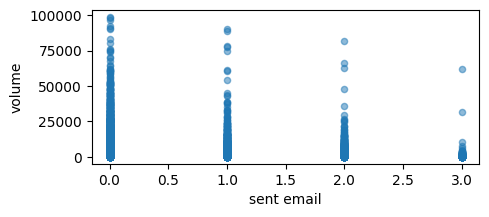

In [27]:
logs_pvt[['sent email', 'volume']].plot(x='sent email', y='volume', kind='scatter', alpha=0.5, figsize=(5, 2))

In [28]:
print("No emails:")
logs_pvt[logs_pvt['sent email']==0][['volume', 'count']].agg(['mean', 'median'])

No emails:


,volume,count
mean,396.324342,3.844309
median,103.000000,1.000000


In [29]:
print("1+ emails:")
logs_pvt[logs_pvt['sent email']>=1][['volume', 'count']].agg(['mean', 'median'])

1+ emails:


,volume,count
mean,639.159501,6.703184
median,207.500000,4.000000


In [30]:
print("2+ emails:")
logs_pvt[logs_pvt['sent email']>=2][['volume', 'count']].agg(['mean', 'median'])

2+ emails:


,volume,count
mean,533.188461,6.098849
median,178.000000,3.000000


In [31]:
print("3+ emails:")
logs_pvt[logs_pvt['sent email']>=3][['volume', 'count']].agg(['mean', 'median'])

3+ emails:


,volume,count
mean,827.141108,7.644886
median,226.670000,4.000000


In [32]:
print("Raising $100+ by emails sent:")

for i in [0, 1, 2, 3]:
    if i == 0:
        m = "0"
        perc = len(logs_pvt[(logs_pvt['sent email']==0)&(logs_pvt['volume']>=100)]) / len(logs_pvt[logs_pvt['sent email']==0])
    else:
        m = "{}+".format(i)
        perc = len(logs_pvt[(logs_pvt['sent email']>=i)&(logs_pvt['volume']>=100)]) / len(logs_pvt[logs_pvt['sent email']>=i])
    print("{}: {:.2f}%".format(m, perc * 100.))

Raising $100+ by emails sent:
0: 58.52%
1+: 76.78%
2+: 74.21%
3+: 77.84%


### social share

<AxesSubplot:xlabel='social share', ylabel='volume'>

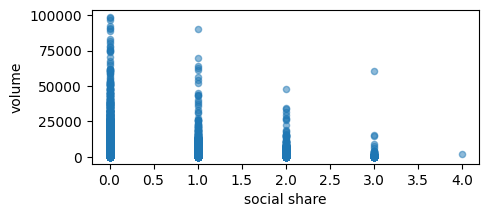

In [33]:
logs_pvt[['social share', 'volume']].plot(x='social share', y='volume', kind='scatter', alpha=0.5, figsize=(5, 2))

In [34]:
print("No sharing:")
logs_pvt[logs_pvt['social share']==0][['volume', 'count']].agg(['mean', 'median'])

No sharing:


,volume,count
mean,407.436604,3.873469
median,103.500000,1.000000


In [35]:
print("1+ shares:")
logs_pvt[logs_pvt['social share']>=1][['volume', 'count']].agg(['mean', 'median'])

1+ shares:


,volume,count
mean,559.602319,6.332214
median,182.000000,3.000000


In [36]:
print("2+ shares:")
logs_pvt[logs_pvt['social share']>=2][['volume', 'count']].agg(['mean', 'median'])

2+ shares:


,volume,count
mean,505.361165,6.256648
median,157.750000,3.000000


In [37]:
print("3+ shares:")
logs_pvt[logs_pvt['social share']>=3][['volume', 'count']].agg(['mean', 'median'])

3+ shares:


,volume,count
mean,946.33279,9.155797
median,292.93000,5.000000


In [38]:
print("Raising $100+ by social shares:")

for i in [0, 1, 2, 3]:
    if i == 0:
        m = "0"
        perc = len(logs_pvt[(logs_pvt['social share']==0)&(logs_pvt['volume']>=100)]) / len(logs_pvt[logs_pvt['social share']==0])
    else:
        m = "{}+".format(i)
        perc = len(logs_pvt[(logs_pvt['social share']>=i)&(logs_pvt['volume']>=100)]) / len(logs_pvt[logs_pvt['social share']>=i])
    print("{}: {:.2f}%".format(m, perc * 100.))

Raising $100+ by social shares:
0: 59.26%
1+: 71.33%
2+: 69.29%
3+: 85.14%


### upload avatar

<AxesSubplot:xlabel='uploaded avatar', ylabel='volume'>

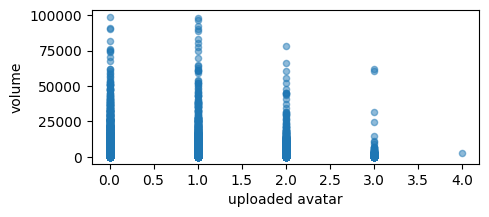

In [39]:
logs_pvt[['uploaded avatar', 'volume']].plot(x='uploaded avatar', y='volume', kind='scatter', alpha=0.5, figsize=(5, 2))

In [40]:
logs_pvt[logs_pvt['uploaded avatar']==0][['volume', 'count']].agg(['mean', 'median'])

,volume,count
mean,314.886863,3.127947
median,100.000000,1.000000


In [41]:
logs_pvt[logs_pvt['uploaded avatar']>=1][['volume', 'count']].agg(['mean', 'median'])

,volume,count
mean,721.66395,7.064922
median,206.00000,3.000000


In [42]:
print("Raised $100+:")

perc_upload = len(logs_pvt[(logs_pvt['volume']>=100)&(logs_pvt['uploaded avatar']>=1)]) / len(logs_pvt[logs_pvt['uploaded avatar']>=1])
perc_noupload = len(logs_pvt[(logs_pvt['volume']>=100)&(logs_pvt['uploaded avatar']==0)]) / len(logs_pvt[logs_pvt['uploaded avatar']==0])

print("{:.2f}% who uploaded avatars raised $100+".format(perc_upload * 100.))
print("{:.2f}% who didn't upload avatars raised $100+".format(perc_noupload * 100.))

Raised $100+:
74.13% who uploaded avatars raised $100+
55.92% who didn't upload avatars raised $100+


In [43]:
print("Reached funddraising goal:")

perc_upload = len(logs_pvt[(logs_pvt['reached fundraising goal']>=1)&(logs_pvt['uploaded avatar']>=1)]) / len(logs_pvt[logs_pvt['uploaded avatar']>=1])
perc_noupload = len(logs_pvt[(logs_pvt['reached fundraising goal']>=1)&(logs_pvt['uploaded avatar']==0)]) / len(logs_pvt[logs_pvt['uploaded avatar']==0])

print("{:.2f}% who uploaded avatars reached fundraising goal".format(perc_upload * 100.))
print("{:.2f}% who didn't upload avatars reached fundraising goal".format(perc_noupload * 100.))

Reached funddraising goal:
48.24% who uploaded avatars reached fundraising goal
46.65% who didn't upload avatars reached fundraising goal


### updated personal page

<AxesSubplot:xlabel='updated personal page', ylabel='volume'>

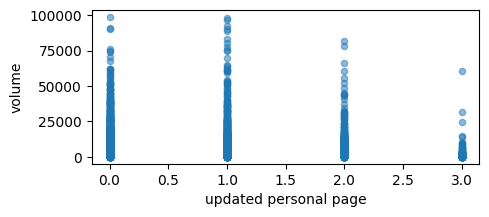

In [44]:
logs_pvt[['updated personal page', 'volume']].plot(x='updated personal page', y='volume', kind='scatter', alpha=0.5, figsize=(5, 2))

In [45]:
logs_pvt[logs_pvt['updated personal page']==0][['volume', 'count']].agg(['mean', 'median'])

,volume,count
mean,321.676042,3.262392
median,100.000000,1.000000


In [46]:
logs_pvt[logs_pvt['updated personal page']>=1][['volume', 'count']].agg(['mean', 'median'])

,volume,count
mean,862.388618,8.154498
median,255.000000,4.000000


In [47]:
print("Raised $100+:")

perc_update = len(logs_pvt[(logs_pvt['volume']>=100)&(logs_pvt['updated personal page']>=1)]) / len(logs_pvt[logs_pvt['updated personal page']>=1])
perc_noupdate = len(logs_pvt[(logs_pvt['volume']>=100)&(logs_pvt['updated personal page']==0)]) / len(logs_pvt[logs_pvt['updated personal page']==0])

print("{:.2f}% who updated personal page raised $100+".format(perc_update * 100.))
print("{:.2f}% who didn't updated personal page raised $100+".format(perc_noupdate * 100.))

Raised $100+:
78.13% who updated personal page raised $100+
56.80% who didn't updated personal page raised $100+


In [48]:
print("Reached fundraising goal:")

perc_update = len(logs_pvt[(logs_pvt['volume']>=100)&(logs_pvt['reached fundraising goal']>=1)]) / len(logs_pvt[logs_pvt['reached fundraising goal']>=1])
perc_noupdate = len(logs_pvt[(logs_pvt['volume']>=100)&(logs_pvt['reached fundraising goal']==0)]) / len(logs_pvt[logs_pvt['reached fundraising goal']==0])

print("{:.2f}% who updated personal page reached fundraising goal".format(perc_update * 100.))
print("{:.2f}% who didn't reached fundraising goal raised $100+".format(perc_noupdate * 100.))

Reached fundraising goal:
79.03% who updated personal page reached fundraising goal
45.14% who didn't reached fundraising goal raised $100+


### badges

- \# badges, mean/median earned
- particular badges driving activity more than others

#### badge names, badges from API

In [3]:
def fetch_table(table):
    url = 'https://secure.qgiv.com/admin/qgivadmin/statistics/export_tables.php'
    payload = {'key': 'DSQR59VwyFhw21PKDF4K', 'table': table}

    rsp = requests.post(url, data=payload)
    json_data = json.loads(rsp.content)

    return json_data

def get_badges_api():
    data = fetch_table("badges")
    df = pd.DataFrame(data[0])
    print("{:,} badges retrieved".format(len(df)))
    return df

In [4]:
badges_df = get_badges_api()

147,175 badges retrieved


In [16]:
badgetype_names = (
    ('ACHIEVEMENT', 1),
    ('ENGAGEMENT', 2),
    ('SENDING', 3),
    ('FUNDRAISING_ACHIEVED', 4),
    ('TOP_FUNDRAISER', 5),
    ('PROFILE_COMPLETED', 6),
    ('SOCIAL_BROADCASTING', 7),
    ('MOST_DONORS', 8),
    ('TEAM_FUNDRAISING_LEADER', 9),
    ('MANUAL', 10),
    ('TEAM_FUNDRAISING_ACHIEVED', 11),
    ('TEAM_TOP_FUNDRAISER', 12),
    ('TEAM_MOST_DONORS', 13),
    ('WELCOME_BACK', 14),
    ('NEW_FUNDRAISING_RECORD', 15),
    ('NEW_DONOR_RECORD', 16),
    ('TEAM_NEW_FUNDRAISING_RECORD', 17),
    ('TEAM_NEW_DONOR_RECORD', 18)
)

#### analysis

In [52]:
print("0 badges performance:")
logs_pvt[logs_pvt['earned badge']==0][['volume', 'count']].agg(['mean', 'median'])

,volume,count
mean,292.942426,3.028549
median,65.000000,1.000000


In [53]:
print("1+ badges performance:")
logs_pvt[logs_pvt['earned badge']>=1][['volume', 'count']].agg(['mean', 'median'])

,volume,count
mean,493.775096,4.807476
median,150.000000,2.000000


<AxesSubplot:xlabel='earned badge', ylabel='volume'>

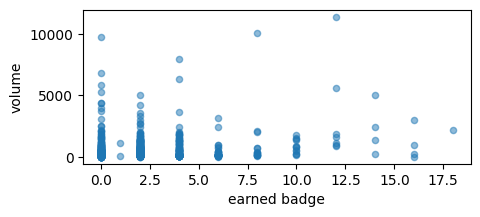

In [54]:
logs_pvt[['earned badge', 'volume']].iloc[:1000].plot(x='earned badge', y='volume', kind='scatter', alpha=0.5, figsize=(5,2))

<AxesSubplot:xlabel='earned badge', ylabel='volume'>

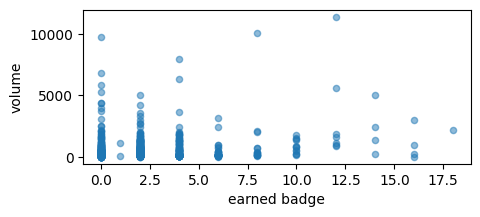

In [55]:
# few examples of extraordinarily high volumes, assume it's an error but even if
# it's legitimate they are not representative of normal fundraiser behavior
logs_pvt[logs_pvt['volume']<100000][['earned badge', 'volume']].iloc[:1000].plot(x='earned badge', y='volume', kind='scatter', alpha=0.5, figsize=(5,2))

In [56]:
pvt_badges = logs_pvt[logs_pvt['volume']<100000]

In [57]:
print("Raised $100+:")

perc_earned = len(pvt_badges[(pvt_badges['volume']>=100)&(pvt_badges['earned badge']>=1)]) / len(pvt_badges[pvt_badges['earned badge']>=1])
perc_notearned = len(pvt_badges[(pvt_badges['volume']>=100)&(pvt_badges['earned badge']==0)]) / len(pvt_badges[pvt_badges['earned badge']==0])

print("{:.2f}% who earned a badge raised $100+".format(perc_earned * 100.))
print("{:.2f}% who didn't didn't earn a badge raised $100+".format(perc_notearned * 100.))

Raised $100+:
70.30% who earned a badge raised $100+
41.04% who didn't didn't earn a badge raised $100+


In [58]:
print("Badges earned by those who raised $100+")
print("Mean: {:.2f} badges".format(pvt_badges[pvt_badges['volume']>=100]['earned badge'].mean()))
print("Median: {:.2f} badges".format(pvt_badges[pvt_badges['volume']>=100]['earned badge'].median()))

Badges earned by those who raised $100+
Mean: 2.03 badges
Median: 2.00 badges


<AxesSubplot:xlabel='earned badge', ylabel='volume'>

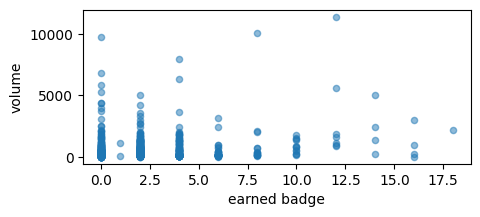

In [59]:
pvt_badges[['earned badge', 'volume']].iloc[:1000].plot(x='earned badge', y='volume', kind='scatter', alpha=0.5, figsize=(5,2))

<AxesSubplot:>

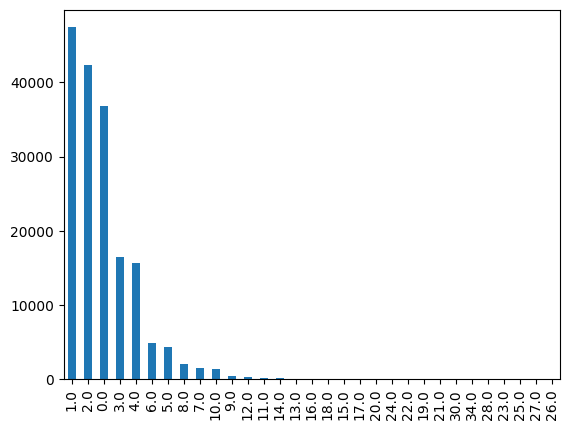

In [60]:
pvt_badges[pvt_badges['volume']>=100]['earned badge'].value_counts().plot(kind='bar')

In [61]:
logs['badge'] = logs['message'].str.extract(r'\%badge_([0-9]+)\%')

In [62]:
badges_logs = logs.merge(badges_df[['badge', 'badgeType']], on='badge')
len_badges_logs, len_len_orig = len(badges_logs), len(logs[~logs['badge'].isna()])

print("{:,} original rows; {:,} merged rows".format(len_len_orig, len_badges_logs))

796,209 original rows; 796,063 merged rows


In [63]:
badges_logs.drop('count', axis=1, inplace=True)
badges_logs = badges_logs.merge(trans, on='entity')
badges_logs.drop(['entitytype_x', 'entitytype_y'], axis=1, inplace=True)

In [64]:
badgetype_df = badges_logs.groupby('badgeType')[['volume', 'count']].agg(['mean', 'median', 'std']).reset_index()

In [65]:
badgetype_df.columns = [" ".join(c).strip() for c in badgetype_df.columns]

In [66]:
badgetype_df['badge'] = badgetype_df['badgeType'].apply(lambda x: [c[0] for c in badgetype_names if c[1]==int(x)][0])

In [67]:
cols = ['badge', 'volume mean', 'volume median', 'count mean', 'count median']
d = badgetype_df[cols].sort_values('count median', ascending=True)
d

,badge,volume mean,volume median,count mean,count median
2,WELCOME_BACK,582.804745,175.0,4.565949,2.0
3,NEW_FUNDRAISING_RECORD,657.636878,208.0,5.216216,2.0
4,NEW_DONOR_RECORD,640.453375,200.0,5.779577,2.0
6,FUNDRAISING_ACHIEVED,541.146153,178.0,5.288781,2.0
10,TEAM_FUNDRAISING_LEADER,451.537906,129.0,4.812991,2.0
0,ACHIEVEMENT,628.894147,210.0,6.308544,3.0
1,MANUAL,585.558500,225.0,5.548835,3.0
7,TOP_FUNDRAISER,1393.516127,441.0,10.764653,4.0
8,PROFILE_COMPLETED,717.352755,250.0,8.250240,4.0
9,MOST_DONORS,1015.234624,260.0,9.630559,4.0


<AxesSubplot:xlabel='badge'>

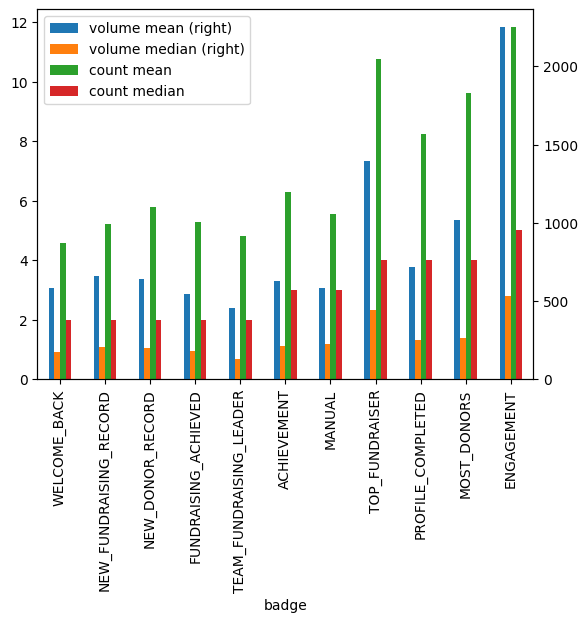

In [68]:
d.plot(x='badge', kind='bar', secondary_y=['volume mean', 'volume median'])

Some of these are self explanatory and should be ignored

In [69]:
badges_to_drop= ('MOST_DONORS', 'TOP_FUNDRAISER', 'NEW_DONOR_RECORD', 
                 'MANUAL', 'ENGAGEMENT', 'ACHIEVEMENT')

d = badgetype_df[~badgetype_df['badge'].isin(badges_to_drop)][cols].sort_values('count median', ascending=False)
d

,badge,volume mean,volume median,count mean,count median
8,PROFILE_COMPLETED,717.352755,250.0,8.250240,4.0
2,WELCOME_BACK,582.804745,175.0,4.565949,2.0
3,NEW_FUNDRAISING_RECORD,657.636878,208.0,5.216216,2.0
6,FUNDRAISING_ACHIEVED,541.146153,178.0,5.288781,2.0
10,TEAM_FUNDRAISING_LEADER,451.537906,129.0,4.812991,2.0


<AxesSubplot:xlabel='badge'>

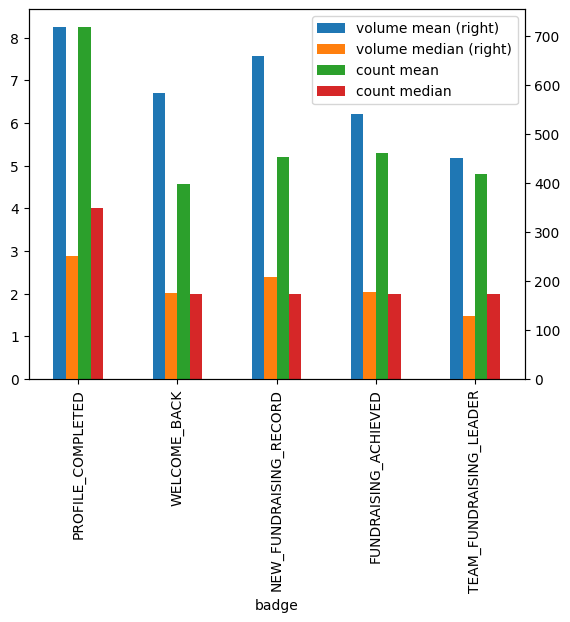

In [70]:
d.plot(x='badge', kind='bar', secondary_y=['volume mean', 'volume median'])

#### continuation

_do badges motivate participation, or do they acknowledge those with high participation?_ we cannot speculate on participant motivation so there is no way to determine with certainty that a fundraiser raised more because they had the chance to earn a badge for their efforts, but we can look at their performance surrounding being awarded the badge. 

presumably, if a participant was working to win the badge, there fundraising would decrease on average after having won the badge. if they are mostly acknowledging high engagement participants, we would expect to see consistent behavior regardless of badge awards. _do participants continue to outperform after being awarded a badge?_

##### build data

In [71]:
len(logs), len(logs[~logs['badge'].isna()])

(3677324, 796209)

In [72]:
logs_badges = logs[~logs['badge'].isna()]

In [73]:
len(logs_badges['org'].unique())

1401

In [74]:
# no longer need trans so clean up
del trans

In [25]:
q = '''select
            transdonationentitytype as entitytype,
            transdonationentity as entity,
            form,
            date,
            sum(amount) as volume,
            count(id) as count
        from transactions
        where
            source='p2p' and
            status='A' and
            date>='2018-01-01' 
        group by transdonationentity, transdonationentitytype, form, date'''
trans_date = redshift_query_read(q, schema='production')

In [76]:
trans_date = trans_date[trans_date['entity'].isin(logs_badges['entity'].tolist())]

In [77]:
len(trans_date), trans_date['date'].min(), trans_date['date'].max()

(606966, Timestamp('2018-01-01 00:00:00'), Timestamp('2024-01-23 00:00:00'))

In [78]:
trans_date.tail(3)

,entitytype,entity,date,volume,count
948648,10,988263,2020-07-25,58.0,1
948651,4,944138,2019-08-02,20.0,1
948657,10,1087904,2021-05-18,100.0,1


In [79]:
pre_post = []
for _, r in logs_badges[logs_badges['entitytype']==10][['entity', 'entitytype', 'created', 'badge']].iterrows():
    these_trans = trans_date[trans_date['entity']==r['entity']]
    
    pre_post.append({
        'entity': r['entity'],
        'entitytype': r['entitytype'],
        'created': r['created'],
        'badge': r['badge'],
        'pre_count': these_trans[these_trans['date']<r['created']]['count'].sum(),
        'pre_vol': these_trans[these_trans['date']<r['created']]['volume'].sum(),
        'post_count': these_trans[these_trans['date']>=r['created']]['count'].sum(),
        'post_vol': these_trans[these_trans['date']>=r['created']]['volume'].sum()
    })

In [82]:
len(pre_post), pre_post[-1]

(796209,
 {'entity': 1667763,
  'entitytype': 10,
  'created': Timestamp('2024-01-23 08:18:15'),
  'badge': '283497',
  'pre_count': 1,
  'pre_vol': 106.0,
  'post_count': 0,
  'post_vol': 0.0})

In [81]:
pre_post_df = pd.DataFrame(pre_post)

In [83]:
pre_post_df.to_csv("badges.csv", index=False)

In [6]:
pre_post_df = pd.read_csv("badges.csv")

In [9]:
badges_df['badge'] = badges_df['badge'].astype(int)
badges_df['badgeType'] = badges_df['badgeType'].astype(int)

In [10]:
pre_post_df = pre_post_df.merge(badges_df[['badge', 'badgeType']], on='badge')

In [17]:
pre_post_df['badgeTypeLabel'] = pre_post_df['badgeType'].apply(lambda x: [c[0] for c in badgetype_names if c[1]==int(x)][0])

In [54]:
pre_post_df['all_count'] = pre_post_df['pre_count'] + pre_post_df['post_count']
pre_post_df['all_vol'] = pre_post_df['pre_vol'] + pre_post_df['post_vol']

##### all

In [21]:
d = pre_post_df.groupby('badgeTypeLabel')[['pre_count', 'post_count']].agg(['mean', 'median']).reset_index()
d.columns = [" ".join(i).strip() for i in d.columns]
d

,badgeTypeLabel,pre_count mean,pre_count median,post_count mean,post_count median
0,ACHIEVEMENT,2.856726,1.0,2.979578,0.0
1,ENGAGEMENT,4.658422,1.0,6.354278,1.0
2,FUNDRAISING_ACHIEVED,3.146483,1.0,1.639419,0.0
3,MANUAL,1.750877,1.0,2.079667,0.0
4,MOST_DONORS,4.600160,1.0,4.963183,1.0
5,NEW_DONOR_RECORD,3.843938,1.0,1.727491,0.0
6,NEW_FUNDRAISING_RECORD,2.252669,1.0,1.067023,0.0
7,PROFILE_COMPLETED,2.735316,1.0,5.396899,2.0
8,TEAM_FUNDRAISING_LEADER,1.696732,1.0,2.016481,0.0
9,TOP_FUNDRAISER,4.898398,1.0,5.693800,1.0


<AxesSubplot:xlabel='badgeTypeLabel'>

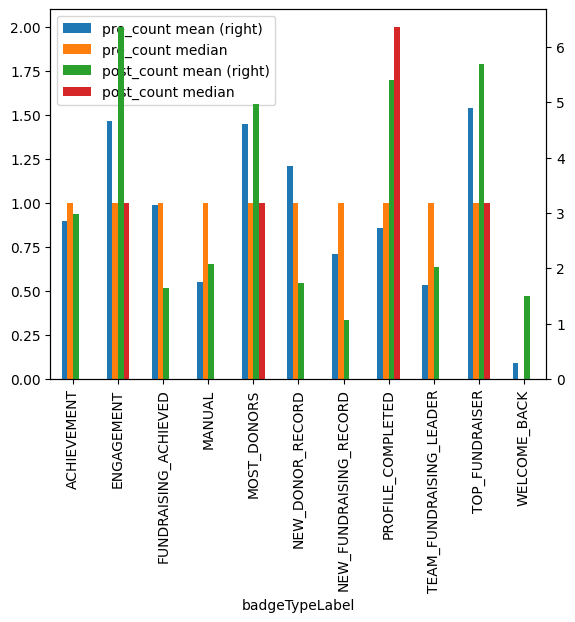

In [22]:
d.plot(x='badgeTypeLabel', kind='bar', secondary_y=['pre_count mean', 'post_count mean'])

In [23]:
d = pre_post_df.groupby('badgeTypeLabel')[['pre_vol', 'post_vol']].agg(['mean', 'median']).reset_index()
d.columns = [" ".join(i).strip() for i in d.columns]
d

,badgeTypeLabel,pre_vol mean,pre_vol median,post_vol mean,post_vol median
0,ACHIEVEMENT,281.502731,105.50,300.314153,0.0
1,ENGAGEMENT,776.157721,104.50,1316.707119,100.0
2,FUNDRAISING_ACHIEVED,320.093869,125.00,169.597941,0.0
3,MANUAL,166.955722,25.00,237.274532,0.0
4,MOST_DONORS,447.755744,105.00,560.393057,50.0
5,NEW_DONOR_RECORD,467.301573,145.00,150.086255,0.0
6,NEW_FUNDRAISING_RECORD,319.108820,63.00,99.422835,0.0
7,PROFILE_COMPLETED,226.138539,78.71,480.952112,100.8
8,TEAM_FUNDRAISING_LEADER,150.938426,50.00,197.422191,0.0
9,TOP_FUNDRAISER,661.072562,179.50,710.118732,52.5


<AxesSubplot:xlabel='badgeTypeLabel'>

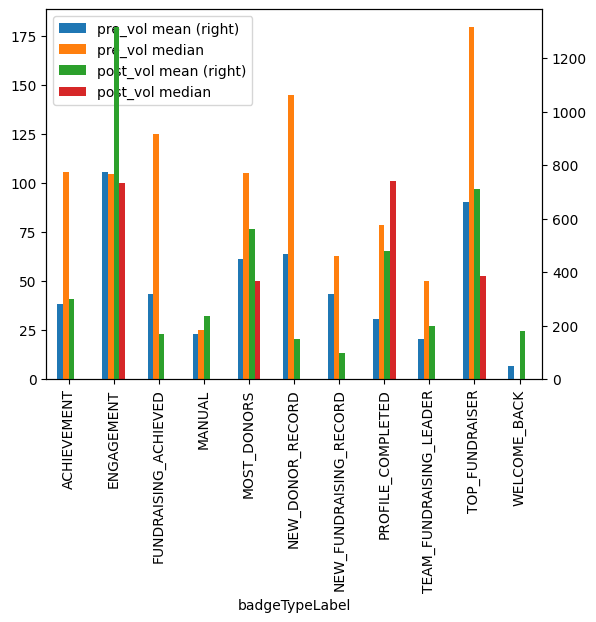

In [24]:
d.plot(x='badgeTypeLabel', kind='bar', secondary_y=['pre_vol mean', 'post_vol mean'])

It looks like there's a dropoff in performance after the badge award, which coincides with my theory that the badge was motivating performance. With the exception of _WELCOME_BACK_ and _PROFILE_COMPLETED_ (for obvious reasons), every other badge shows a significant decrease in fundraising after the badge is awarded. 

Donation counts are less clear. The median's are all the same value or lower, but the values are all 1 and 0 so I'm not sure howw meaningful that is. The means are more mixed but mostly represent a modest gain where the pattern is reversed.

##### segmenting

removing the top/bottom 10%

In [58]:
parts = pre_post_df.sort_values('all_count')['entity'].unique().tolist()

len_pt = len(parts)
ten_perc = int(len_pt * .1)

middle_80 = parts[ten_perc:-ten_perc]

In [59]:
pre_post_mid80 = pre_post_df[pre_post_df['entity'].isin(middle_80)]

len(pre_post_df), len(pre_post_df['entity'].unique()), len(pre_post_mid80), len(pre_post_mid80['entity'].unique())

(796063, 265873, 604883, 212699)

In [62]:
d = pre_post_mid80.groupby('badgeTypeLabel')[['pre_vol', 'post_vol']].agg(['mean', 'median', 'count']).reset_index()
d.columns = [" ".join(i).strip() for i in d.columns]
d['count'] = d['pre_vol count']
d.drop(['pre_vol count', 'post_vol count'], axis=1, inplace=True)
d

,badgeTypeLabel,pre_vol mean,pre_vol median,post_vol mean,post_vol median,count
0,ACHIEVEMENT,196.202825,103.0,83.935809,0.0,112321
1,ENGAGEMENT,390.051710,100.0,212.612284,0.0,924
2,FUNDRAISING_ACHIEVED,192.735576,106.0,45.335322,0.0,137263
3,MANUAL,135.452826,50.0,111.569030,0.0,10789
4,MOST_DONORS,162.155031,85.0,115.590844,0.0,52022
5,NEW_DONOR_RECORD,264.614851,105.0,65.771935,0.0,672
6,NEW_FUNDRAISING_RECORD,212.186369,100.0,50.142869,0.0,1220
7,PROFILE_COMPLETED,121.491671,60.0,147.211578,51.5,10853
8,TEAM_FUNDRAISING_LEADER,111.511109,50.0,65.036330,0.0,235521
9,TOP_FUNDRAISER,311.609213,120.0,148.535799,0.0,40004


badge awards grouped by whether or not a given participant achieved the profile completed badge

In [66]:
parts_comp_profile = pre_post_df[pre_post_df['badgeTypeLabel']=='PROFILE_COMPLETED']['entity'].unique().tolist()

len(parts_comp_profile), len(pre_post_df['entity'].unique()), len(parts_comp_profile)/len(pre_post_df['entity'].unique())

(12566, 265873, 0.04726316700078609)

In [70]:
parts_perf = pre_post_df.groupby('entity')[['all_count', 'all_vol']].first().reset_index()
parts_perf['completed profile'] = parts_perf['entity'].isin(parts_comp_profile)

In [74]:
parts_perf.groupby('completed profile')[['all_count', 'all_vol']].agg(['mean', 'median']).reset_index()

completed profile all_count            all_vol       
                         mean median        mean median
0             False  3.558291    1.0  369.936377  100.0
1              True  8.387076    4.0  746.239003  250.0

#### inspiration

_do events with the top performing badges have higher average fundraising numbers?_

In [26]:
trans_date.tail(2)

,entitytype,entity,form,date,volume,count
1088868,10,1087904,968288,2021-05-18,100.0,1
1088869,2,845230,946880,2019-10-31,50.0,1


In [44]:
topfund_participants = pre_post_df[pre_post_df['badgeType']==5]['entity'].tolist()
topfund_forms = trans_date[trans_date['entity'].isin(topfund_participants)]['form'].unique().tolist()

profcomp_participants = pre_post_df[pre_post_df['badgeType']==6]['entity'].tolist()
profcomp_forms = trans_date[trans_date['entity'].isin(profcomp_participants)]['form'].unique().tolist()

In [45]:
trans_date['has topfund'] = trans_date['form'].isin(topfund_forms)
trans_date['has profcomp'] = trans_date['form'].isin(profcomp_forms)

In [51]:
trans_date.groupby(['has topfund'])[['volume', 'count']].agg(['mean', 'median']).reset_index()

has topfund      volume            count       
                     mean median      mean median
0       False  316.922808   84.0  2.879676    1.0
1        True  159.934472   53.0  1.920501    1.0

In [47]:
trans_date['has topfund'].value_counts()

True     966276
False    122594
Name: has topfund, dtype: int64

In [48]:
trans_date.groupby('has profcomp')[['volume', 'count']].agg(['mean', 'median']).reset_index()

has profcomp      volume            count       
                      mean median      mean median
0        False  258.793452  70.00  2.406094    1.0
1         True  152.739091  52.97  1.912816    1.0

In [49]:
trans_date['has profcomp'].value_counts()

True     833523
False    255347
Name: has profcomp, dtype: int64